In [1]:
import math
import time
from copy import deepcopy
import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import ticker
from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import energy_of_membrane, energy_of_synapse
from sbi.analysis import ActiveSubspace

import stg_energy.fig3_active_subspaces.viz as viz
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin

# Figure 3

In [2]:
pd.options.display.max_columns = 999

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
PANEL_A = "../svg/panel_a.svg"
PANEL_B = "../svg/panel_b.svg"
PANEL_B_raw = "../svg/panel_b_raw.svg"
PANEL_C = "../svg/panel_c_act.svg"
PANEL_C_act = "../svg/panel_c_act.svg"
PANEL_D = "../svg/panel_d_act.svg"
PANEL_E1 = "../svg/panel_e1_act.svg"
PANEL_E2 = "../svg/panel_e2_act.svg"
PANEL_F1 = "../svg/panel_f1_act.svg"
PANEL_F1_raw = "../svg/panel_f1_raw.svg"
PANEL_F2 = "../svg/panel_f2.svg"
PANEL_G1 = "../svg/panel_g1.svg"
PANEL_G2 = "../svg/panel_g2.svg"
PANEL_H1 = "../svg/panel_h1.svg"
PANEL_H2 = "../svg/panel_h2.svg"
PANEL_I1 = "../svg/panel_i1.svg"
PANEL_I2 = "../svg/panel_i2.svg"

PANEL_supp_EV1 = "../svg/panel_supp_ev1.svg"
PANEL_supp_EV2 = "../svg/panel_supp_ev2.svg"
PANEL_supp_EV3 = "../svg/panel_supp_ev3.svg"

PANEL_supp_shift1 = "../svg/panel_supp_shift1.svg"
PANEL_supp_shift2 = "../svg/panel_supp_shift2.svg"
PANEL_supp_shift3 = "../svg/panel_supp_shift3.svg"
PANEL_supp_shift4 = "../svg/panel_supp_shift4.svg"
PANEL_supp_shift5 = "../svg/panel_supp_shift5.svg"
PANEL_supp_shift6 = "../svg/panel_supp_shift6.svg"
PANEL_supp_shift7 = "../svg/panel_supp_shift7.svg"

PANEL_supp_performance1 = "../svg/panel_supp_performance1_act.svg"
PANEL_supp_performance2 = "../svg/panel_supp_performance2_act.svg"
PANEL_supp_performance3 = "../svg/panel_supp_performance3_act.svg"

PANEL_supp_synapses1 = "../svg/panel_supp_synapses1_act.svg"
PANEL_supp_synapses2 = "../svg/panel_supp_synapses2_act.svg"
PANEL_supp_synapses3 = "../svg/panel_supp_synapses3_act.svg"

PANEL_NEW_A = "../svg/panel_new_a_inkscape.svg"

PANEL_NEW_F1 = "../svg/panel_new_f1.svg"
PANEL_NEW_F2 = "../svg/panel_new_f2.svg"

PANEL_NEW_G1 = "../svg/panel_new_g1.svg"
PANEL_NEW_G2 = "../svg/panel_new_g2.svg"
PANEL_NEW_supp_params_11 = "../svg/PANEL_NEW_supp_params_11.svg"
PANEL_NEW_supp_params_12 = "../svg/PANEL_NEW_supp_params_12.svg"
PANEL_NEW_supp_params_21 = "../svg/PANEL_NEW_supp_params_21.svg"
PANEL_NEW_supp_params_22 = "../svg/PANEL_NEW_supp_params_22.svg"

PANEL_REG_supp_bar = "../svg/panel_reg_supp_bar.svg"

### Load experimental data

In [5]:
prior_11 = create_prior()

In [6]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

###  Fit regression net for total energy

In [7]:
import sys
sys.path.append("home/michael/Documents/sbi/sbi/utils/user_input_checks_utils")

In [8]:
import sys
from sbi.utils import user_input_checks_utils

sys.modules["sbi.user_input.user_input_checks_utils"] = user_input_checks_utils

In [10]:
posterior._x

In [9]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)
    posterior._device = 'cpu'

/home/michael/Documents/STG_energy_sbi/sbi/inference/posteriors/base_posterior.py:1089: UserWarning: You had saved the posterior under an older version of `sbi`. To make the loaded version comply with the version you are using right now, we had to set the following attributes: `self._device = cpu` `self._num_iid_trials = None` `self._iid_methods = ['snle', 'snre_a', 'snre_b']` `self._allow_iid_x = False` `self._sample_with = rejection`
  warn(warning_description + warning_msg)


In [11]:
xo = np.load("../../../results/experimental_data/xo_11deg.npy")

In [12]:
xo

array([1.17085859e+03, 2.06036434e+02, 2.14307031e+02, 4.12842187e+02,
       1.75970382e-01, 1.83034085e-01, 3.52597820e-01, 4.11600328e-01,
       6.30544893e-01, 4.81925781e+02, 2.56353125e+02, 2.75164844e+02,
       4.20460938e+01, 2.35011166e-01, 3.59104797e-02, 2.50000000e+00,
       2.50000000e+00, 2.50000000e+00])

In [11]:
energies = x["energies"]

In [12]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

In [13]:
num_test = 1000

theta_test = torch.as_tensor(theta_np[:num_test], dtype=torch.float32)
theta_train = torch.as_tensor(theta_np[num_test:], dtype=torch.float32)

In [14]:
train_energy = torch.as_tensor(
    torch.sum(energies_tt[num_test:], dim=1).unsqueeze(1), dtype=torch.float32
)
test_energy = torch.as_tensor(
    torch.sum(energies_tt[:num_test], dim=1).unsqueeze(1), dtype=torch.float32
)

In [15]:
posterior._sample_with = "rejection"

In [16]:
# torch.manual_seed(0)
# sensitivity = ActiveSubspace(posterior.set_default_x(xo))
# converged_nn = sensitivity.add_property(
#     theta_train, train_energy, hidden_features=20, num_blocks=1
# ).train()

In [17]:
# with open("../../../results/regression_nets/210717_total_energy.npy", "wb") as handle:
#     pickle.dump(converged_nn, handle)
# with open("../../../results/regression_nets/210717_sensitivity_total_energy.npy", "wb") as handle:
#     pickle.dump(sensitivity, handle)

In [18]:
with open("../../../results/regression_nets/210717_total_energy.npy", "rb") as handle:
    converged_nn = pickle.load(handle)
with open("../../../results/regression_nets/210717_sensitivity_total_energy.npy", "rb") as handle:
    sensitivity = pickle.load(handle)

In [19]:
torch.manual_seed(0)
e_vals, e_vecs = sensitivity.find_directions()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
predictions = converged_nn(theta_test).detach()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif


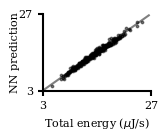

In [21]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 1.0))
    unnorm_x = test_energy[:300]
    unnorm_y = predictions[:300]
    ax.scatter(x=unnorm_x.numpy()/10/1000, y=unnorm_y/10/1000, s=3, color="k", alpha=0.5)
    ax.plot([3, 26.5], [3, 26.5], "k", alpha=0.5)
    ax.set_xlabel("Total energy ($\mu$J/s)")
    ax.set_ylabel("NN prediction", labelpad=-1)
    ax.set_xticks([3, 27])
    ax.set_yticks([3, 27])
    ax.set_xlim([3, 27])
    ax.set_ylim([3, 27])
    plt.savefig(PANEL_supp_performance1, facecolor='None', transparent=False)

In [22]:
unnorm_y = predictions[:300]
mse = torch.mean(torch.abs(unnorm_x/10/1000 - unnorm_y/10/1000) ** 2)
print("mean squared error: ", mse)

mean squared error:  tensor(0.2351)


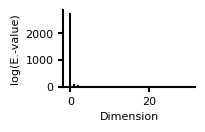

In [23]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_eigenvalues(
        torch.abs(torch.flip(e_vals, dims=(0,))),
        figsize=(1.7, 1.0),
        ylabel="log(E.-value)",
        color="k",
        title=None
    )
    plt.savefig(PANEL_supp_EV1, facecolor="None", transparent=False)
    plt.show()

In [24]:
print("Ratio of first two eigenvalues:  ", e_vals[-1] / e_vals[-2])

Ratio of first two eigenvalues:   tensor(24.6975)


In [25]:
print("Fraction of first to total: ", e_vals[-1] / torch.sum(e_vals))

Fraction of first to total:  tensor(0.9147)


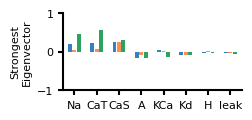

In [26]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        e_vecs[:, -1].T,
        ylim=[-1, 1.0],
        figsize=(2.3, 1.0),
        ylabel='Strongest\nEigenvector',
        plot_labels=True,
        legend=False,
        title=None,
        yticks=[-1, 0, 1]
    )
    plt.savefig(PANEL_C_act, facecolor="None", transparent=False)
    plt.show()

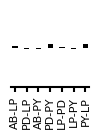

In [27]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        deepcopy(e_vecs[24:, -1:].T), ylim=[-1, 1], figsize=(1.0, 1.0), ylabel=None, color="k", title=None, width_multiplier=0.5
    )
    plt.savefig(PANEL_supp_synapses1, facecolor="None", transparent=False)
    plt.show()

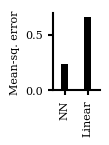

In [28]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(0.6, 1.0))
    mse_nn = 0.657416062903956 # see notebook 02_build_figure.ipynb
    ax.bar(np.arange(2), [mse, mse_nn], facecolor='k', width=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel("Mean-sq. error")
    ax.set_xticks([0.0, 1.0])
    ax.set_xlim([-0.5, 1.5])
    ax.set_xticklabels(['NN', 'Linear'], rotation=90)
    plt.savefig(PANEL_REG_supp_bar, facecolor='None', transparent=False)

### Assembe figure

In [29]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [30]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "3.4cm",

    Panel(
          SVG(PANEL_supp_performance1).scale(svg_scale).move(0, 0*factor_svg),
          Text("a", -1*factor_svg, 2.3*factor_svg, **kwargs_text),
    ).move(1*factor_svg, 0.0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_EV1).scale(svg_scale).move(0, 0*factor_svg),
          Text("b", -1*factor_svg, 1.6*factor_svg, **kwargs_text),
    ).move(33*factor_svg, 0.7*factor_svg),
           
    Panel(
          SVG(PANEL_C_act).scale(svg_scale).move(0, 0*factor_svg),
          Text("c", -1*factor_svg, 2.3*factor_svg, **kwargs_text),
    ).move(70*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_synapses1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(110*factor_svg, 0.7*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_supp2.svg")
svg('../fig/fig3_supp2.svg')